In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, sub_and_predict, pred_with_new_weights
from Area2_analysis.lr_funcs import mp_fit_lag_r2, mp_sub_lag_r2
matplotlib.rc('font', size=18)

In [2]:
dataset = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)

In [4]:
xy_vel = dataset.data['hand_vel'].to_numpy()
xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
dataset.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
dataset.resample(5)
dataset.smooth_spk(40, name='smth_40')

active_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
trial_mask = active_mask
n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset.data.spikes.shape[1]
print(n_neurons,'neurons')


193 trials
65 neurons


In [5]:
#make dictionary for trial condition (reaching directions) for Stratified CV
trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == False) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir'] == direction) & (dataset.trial_info['ctr_hold_bump'] == True) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

193 active trials
171 passive trials
[1. 1. 6. 4. 1. 4. 7. 0. 2. 5. 6. 2. 1. 1. 5. 7. 1. 1. 2. 2. 5. 0. 6. 0.
 0. 0. 3. 7. 7. 0. 7. 0. 3. 0. 7. 7. 5. 3. 0. 7. 3. 0. 6. 4. 3. 0. 0. 4.
 3. 3. 6. 1. 0. 2. 0. 6. 2. 0. 5. 4. 7. 6. 3. 1. 5. 3. 0. 4. 6. 6. 0. 1.
 3. 0. 6. 3. 1. 4. 3. 4. 5. 2. 2. 3. 3. 3. 4. 4. 2. 1. 2. 2. 4. 6. 1. 5.
 0. 2. 0. 4. 6. 5. 6. 3. 0. 0. 3. 3. 7. 5. 5. 3. 1. 5. 0. 7. 4. 7. 5. 5.
 1. 6. 3. 3. 2. 1. 7. 5. 5. 0. 1. 6. 2. 7. 1. 0. 0. 3. 4. 1. 2. 0. 3. 0.
 2. 5. 1. 3. 4. 1. 6. 5. 6. 3. 7. 5. 2. 0. 0. 5. 0. 6. 4. 2. 2. 7. 0. 4.
 4. 7. 5. 2. 6. 3. 2. 5. 5. 1. 1. 5. 5. 1. 6. 3. 7. 0. 4. 2. 1. 5. 1. 1.
 1.]
193
[0. 6. 3. 5. 2. 7. 5. 3. 5. 4. 3. 6. 1. 4. 6. 7. 1. 5. 2. 4. 3. 0. 4. 0.
 6. 2. 5. 7. 5. 7. 6. 7. 6. 2. 2. 2. 0. 6. 2. 0. 6. 7. 3. 4. 0. 6. 2. 0.
 4. 3. 0. 7. 0. 0. 0. 7. 2. 5. 3. 5. 2. 7. 2. 5. 7. 3. 1. 4. 0. 6. 0. 6.
 2. 4. 3. 5. 0. 0. 7. 6. 7. 5. 6. 4. 0. 4. 1. 2. 5. 1. 4. 0. 5. 6. 3. 3.
 7. 5. 6. 0. 1. 7. 7. 3. 3. 5. 2. 7. 1. 7. 3. 5. 1. 0. 2. 0. 0. 2. 6. 0.
 5. 3

# Original neurons

In [61]:
active_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100,500), ignored_trials=~active_mask)
passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100,500), ignored_trials=~passive_mask)
active_spikes = active_df.spikes_smth_40.to_numpy().reshape(active_n_trials, -1, n_neurons)
passive_spikes = passive_df.spikes_smth_40.to_numpy().reshape(passive_n_trials, -1, n_neurons)


Text(0, 0.5, 'sp')

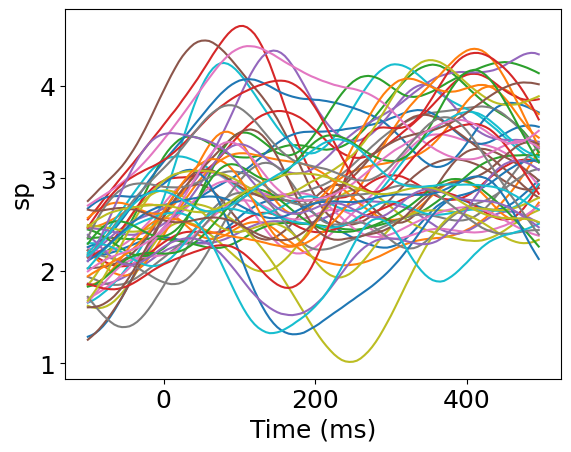

In [135]:
plt.plot(np.arange(-100,500,5),np.sum(active_spikes,axis = 2)[:50,:].T)
# plt.plot(np.arange(-100,500,5),np.mean(active_spikes,axis=0)[:,:50])
plt.xlabel('Time (ms)')
plt.ylabel('sp')

Text(0, 0.5, 'sp')

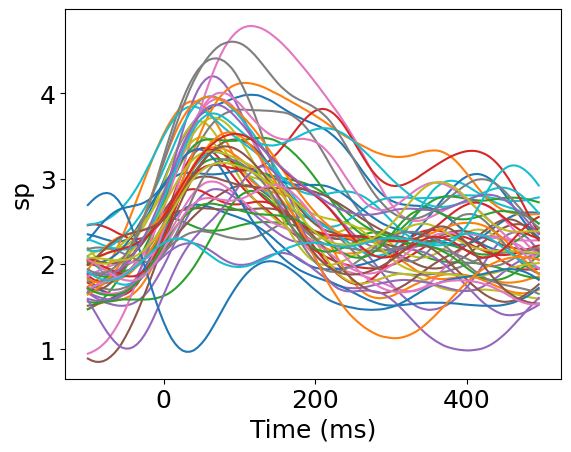

In [136]:
plt.plot(np.arange(-100,500,5),np.sum(passive_spikes,axis = 2)[:50,:].T)
# plt.plot(np.arange(-100,500,5),np.mean(passive_spikes,axis=0)[:,:50])
plt.xlabel('Time (ms)')
plt.ylabel('sp')

0


Text(0, 0.5, 'R2')

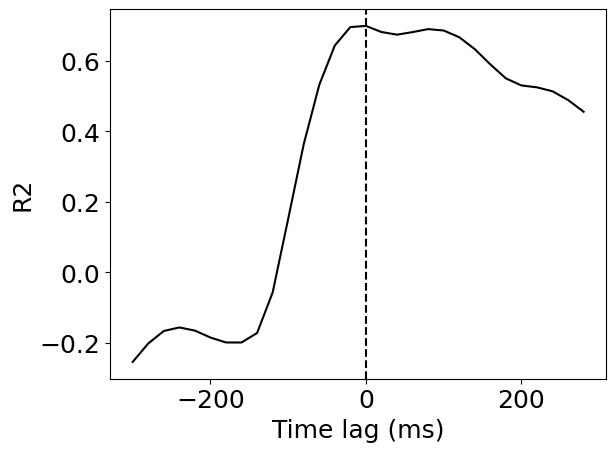

In [10]:
dataset = dataset
x_field = 'spikes_smth_40'
y_field ='hand_vel'
lag_axis = np.arange(-300,300,20)
dim = n_neurons

trial_mask = passive_mask
cond_dict = passive_cond_dict
pred_range = (-100, 120)
r2_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
for i in range(len(lag_axis)):
    lag = lag_axis[i]
    r2, coef,_,_ = fit_and_predict(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict)
    r2_array[i] = r2
    coef_array[i,:,:] = coef
time_max = lag_axis[np.argmax(r2_array)]
print(time_max)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')

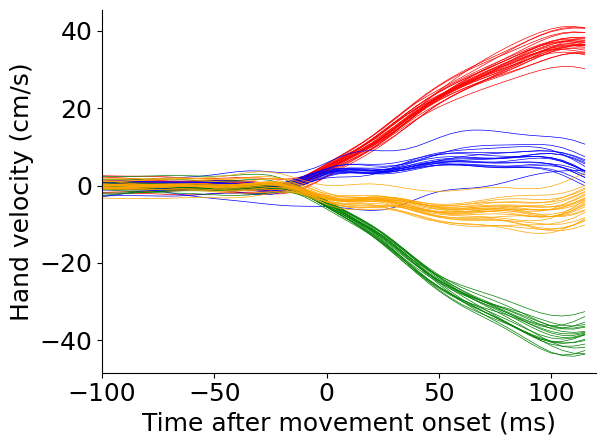

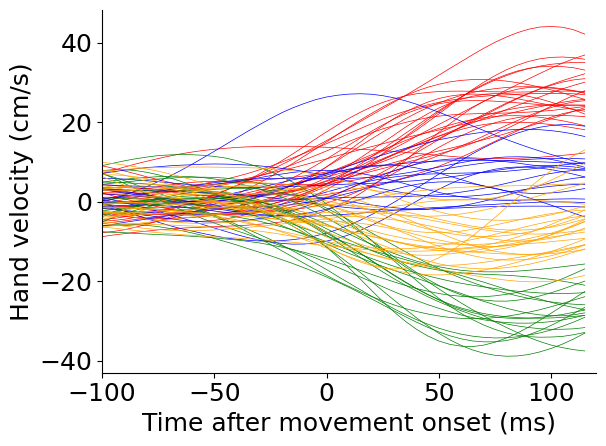

In [11]:
_, weights, _,vel_df = fit_and_predict(dataset, trial_mask, 'move_onset_time',(-100,120), time_max, x_field, y_field, cond_dict)
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']
x_axis = np.arange(-100,120,5)

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity (cm/s)')
plt.xlim([-100,120])
# plt.ylim([-0.5,0.5])
plt.tight_layout()
plt.show()


fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity (cm/s)')
plt.xlim([-100,120])
plt.tight_layout()
plt.show()

In [226]:
sub_r2_array = [mp_sub_lag_r2(dataset, trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, weights, cond_dict) for lag in lag_axis]
time_max = lag_axis[np.argmax(sub_r2_array)]

In [227]:
_, new_weights, _, vel_df = sub_and_predict(dataset, trial_mask, 'move_onset_time', pred_range, time_max, x_field, y_field,weights, cond_dict)

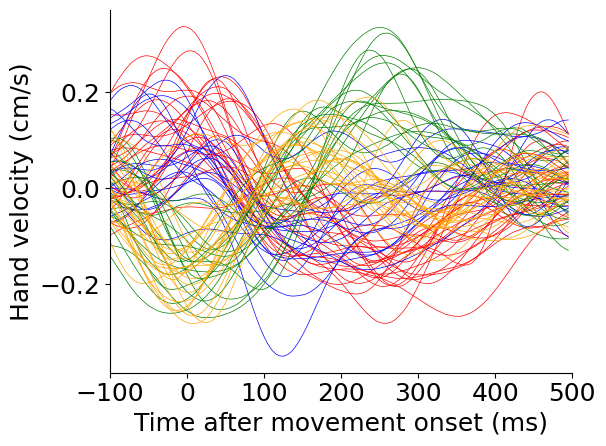

100


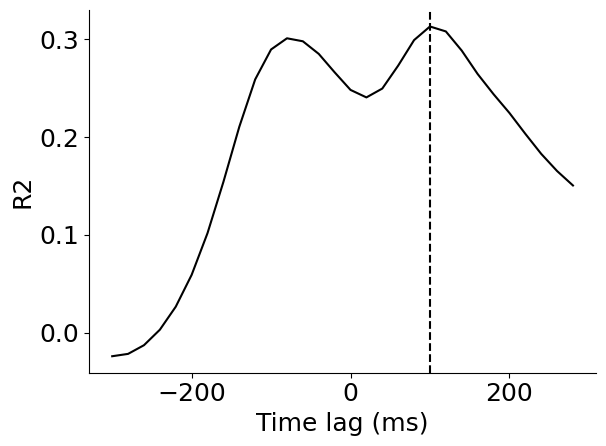

In [228]:
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity (cm/s)')
plt.xlim([-100,500])
# plt.ylim([-0.5,0.5])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, sub_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(time_max)
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.tight_layout()
plt.show()

# AutoLFADS

In [12]:
both_mask = (dataset.trial_info.split != 'none')
n_trials = dataset.trial_info.loc[both_mask].shape[0]
print(n_trials,'trials')
both_trials_idx = np.array(dataset.trial_info.loc[both_mask]['trial_id'])

364 trials


In [13]:
active_mask = (~dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
active_n_trials = dataset.trial_info.loc[active_mask].shape[0]
print(active_n_trials,'trials')
active_trials_idx = np.array(dataset.trial_info.loc[active_mask]['trial_id'])

193 trials


In [14]:
passive_mask = (dataset.trial_info.ctr_hold_bump) & (dataset.trial_info.split != 'none')
passive_n_trials = dataset.trial_info.loc[passive_mask].shape[0]
print(passive_n_trials,'trials')
passive_trials_idx = np.array(dataset.trial_info.loc[passive_mask]['trial_id'])

171 trials


In [15]:
import h5py
foldername = "/Users/sherryan/area2_population_analysis/s1-kinematics/autolfads/"
filename = foldername + "area2_bump_autolfads_submission.h5"
f = h5py.File(filename, "r")
f = f['area2_bump']
for key in f.keys():
    print(key)

eval_rates_heldin
eval_rates_heldin_forward
eval_rates_heldout
eval_rates_heldout_forward
train_rates_heldin
train_rates_heldout


In [16]:
combine_rates_array = np.concatenate([f['train_rates_heldin'][()],f['train_rates_heldout'][()]],axis = 2)
print(combine_rates_array.shape)

(364, 120, 65)


In [170]:
# train_inds = f['train_inds'][()]
# valid_inds = f['valid_inds'][()]
# train_factors = f['train_factors'][()]
# train_rates = f['train_rates'][()]
# valid_factors = f['valid_factors'][()]
# valid_rates = f['valid_rates'][()]
# print(train_factors.shape)
# print(valid_factors.shape)
# f.close()
# n_factors = train_factors.shape[2]
# n_timepoints = train_rates.shape[1]
# print(n_factors,'factors')
# print(n_timepoints,'timepoints')

In [171]:
# combine_rates_array = nans([n_trials, n_timepoints, n_neurons]) #364*160*65
# combine_factors_array = nans([n_trials, n_timepoints, n_factors]) #364*160*40
# for i in range(n_trials):
#     if i in train_inds:
#         loc = np.argwhere(train_inds==i)[0,0]
#         rates = train_rates[loc,:,:]
#         factors = train_factors[loc,:,:]
#     if i in valid_inds: 
#         loc = np.argwhere(valid_inds==i)[0,0]
#         rates = valid_rates[loc,:,:]
#         factors = valid_factors[loc,:,:]
#     combine_rates_array[i,:,:] = rates
#     combine_factors_array[i,:,:] = factors

In [17]:
active_rates_array = nans([active_n_trials, 120, n_neurons])
passive_rates_array = nans([passive_n_trials, 120, n_neurons])
c=0
for i in active_trials_idx:
    loc = np.argwhere(both_trials_idx==i)[0,0]
    active_rates_array[c,:,:]= combine_rates_array[loc,:,:]
    # active_factors_array[c,:,:]= combine_factors_array[loc,:,:]
    c+=1
c=0
for i in passive_trials_idx:
    loc = np.argwhere(both_trials_idx==i)[0,0]
    passive_rates_array[c,:,:]= combine_rates_array[loc,:,:]
    # passive_factors_array[c,:,:]= combine_factors_array[loc,:,:]
    c+=1
print(active_rates_array.shape)
print(passive_rates_array.shape)

(193, 120, 65)
(171, 120, 65)


Text(0, 0.5, 'sp')

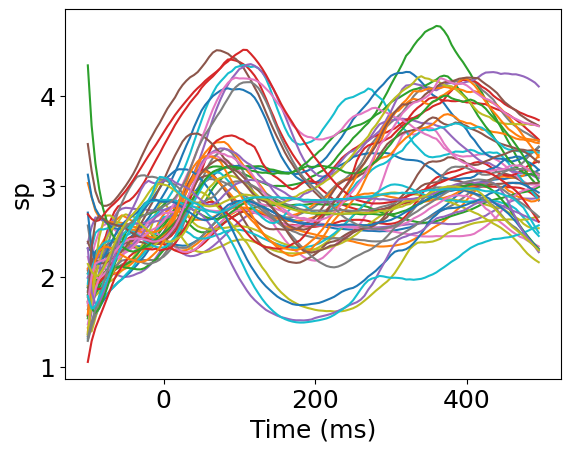

In [137]:
plt.plot(np.arange(-100,500,5),np.sum(active_rates_array,axis = 2)[:50,:].T)
# plt.plot(np.arange(-100,500,5),np.mean(active_rates_array,axis=0)[:,:50])

plt.xlabel('Time (ms)')
plt.ylabel('sp')

Text(0, 0.5, 'sp')

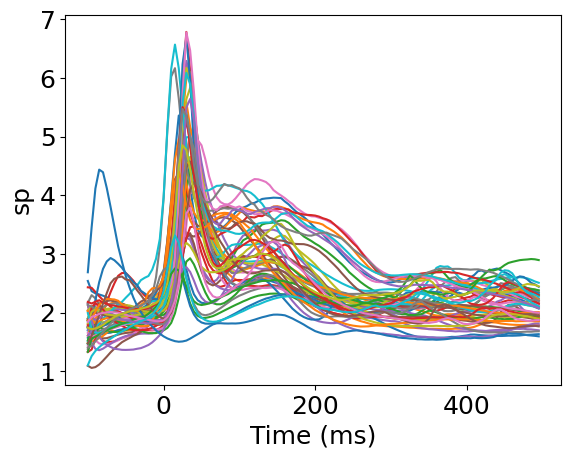

In [138]:
plt.plot(np.arange(-100,500,5),np.sum(passive_rates_array,axis = 2)[:50,:].T)
# plt.plot(np.arange(-100,500,5),np.mean(passive_rates_array,axis=0)[:,:50])
plt.xlabel('Time (ms)')
plt.ylabel('sp')

In [171]:
active_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100,500), ignored_trials=~active_mask)
active_acc_array = active_df['hand_acc'].to_numpy().reshape(active_n_trials,120,2)
active_vel_array = active_df['hand_vel'].to_numpy().reshape(active_n_trials,120,2)
print(active_acc_array.shape)

passive_df = dataset.make_trial_data(align_field='move_onset_time', align_range=(-100,500), ignored_trials=~passive_mask)
passive_acc_array = passive_df['hand_acc'].to_numpy().reshape(passive_n_trials,120,2)
passive_vel_array = passive_df['hand_vel'].to_numpy().reshape(passive_n_trials,120,2)
print(passive_acc_array.shape)

(193, 120, 2)
(171, 120, 2)


In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

vel_axis = np.arange(-100, 500, dataset.bin_width)
lag_axis = np.arange(-100, 100, 5)
active_coefs_arr = nans([len(lag_axis), 2,n_neurons])
active_r2 = nans([len(lag_axis)])
kinemaic_array = active_vel_array

y_trial = kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==400)[0,0],:]
y_flat = y_trial.reshape(-1,2)
for i in range(len(lag_axis)):
    start, end = 0+i, -40+i
    X_trial = active_rates_array[:,start:end,:]
    lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-4,4,9)})
    X_flat = X_trial.reshape((X_trial.shape[0]* X_trial.shape[1]),X_trial.shape[2])
    X_proc = (X_flat - np.nanmean(X_flat,axis=0))/np.nanstd(X_flat,axis=0)
    y_proc = (y_flat - np.nanmean(y_flat,axis=0))/np.nanstd(y_flat,axis=0)
    lr_all.fit(X_proc, y_proc)
    active_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_

    kf = KFold(n_splits=5, shuffle = True, random_state = 42)
    true_concat = nans([len(y_flat),2])
    pred_concat = nans([len(y_flat),2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,active_n_trials)):
            X_train, X_test, y_train, y_test = process_train_test(X_trial,y_trial,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)

            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean) 
    active_r2[i] = R2

15


Text(0, 0.5, 'R2')

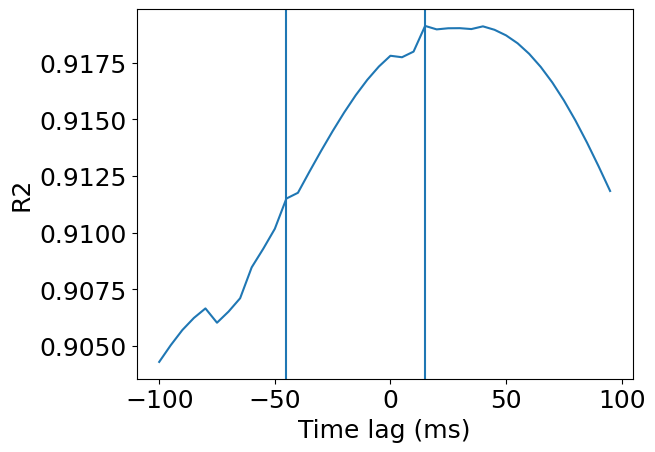

In [193]:
plt.plot(lag_axis, active_r2)
print(lag_axis[np.argmax(active_r2)])
plt.axvline(lag_axis[np.argmax(active_r2)])
plt.axvline(-45)

plt.xlabel("Time lag (ms)")
plt.ylabel('R2')

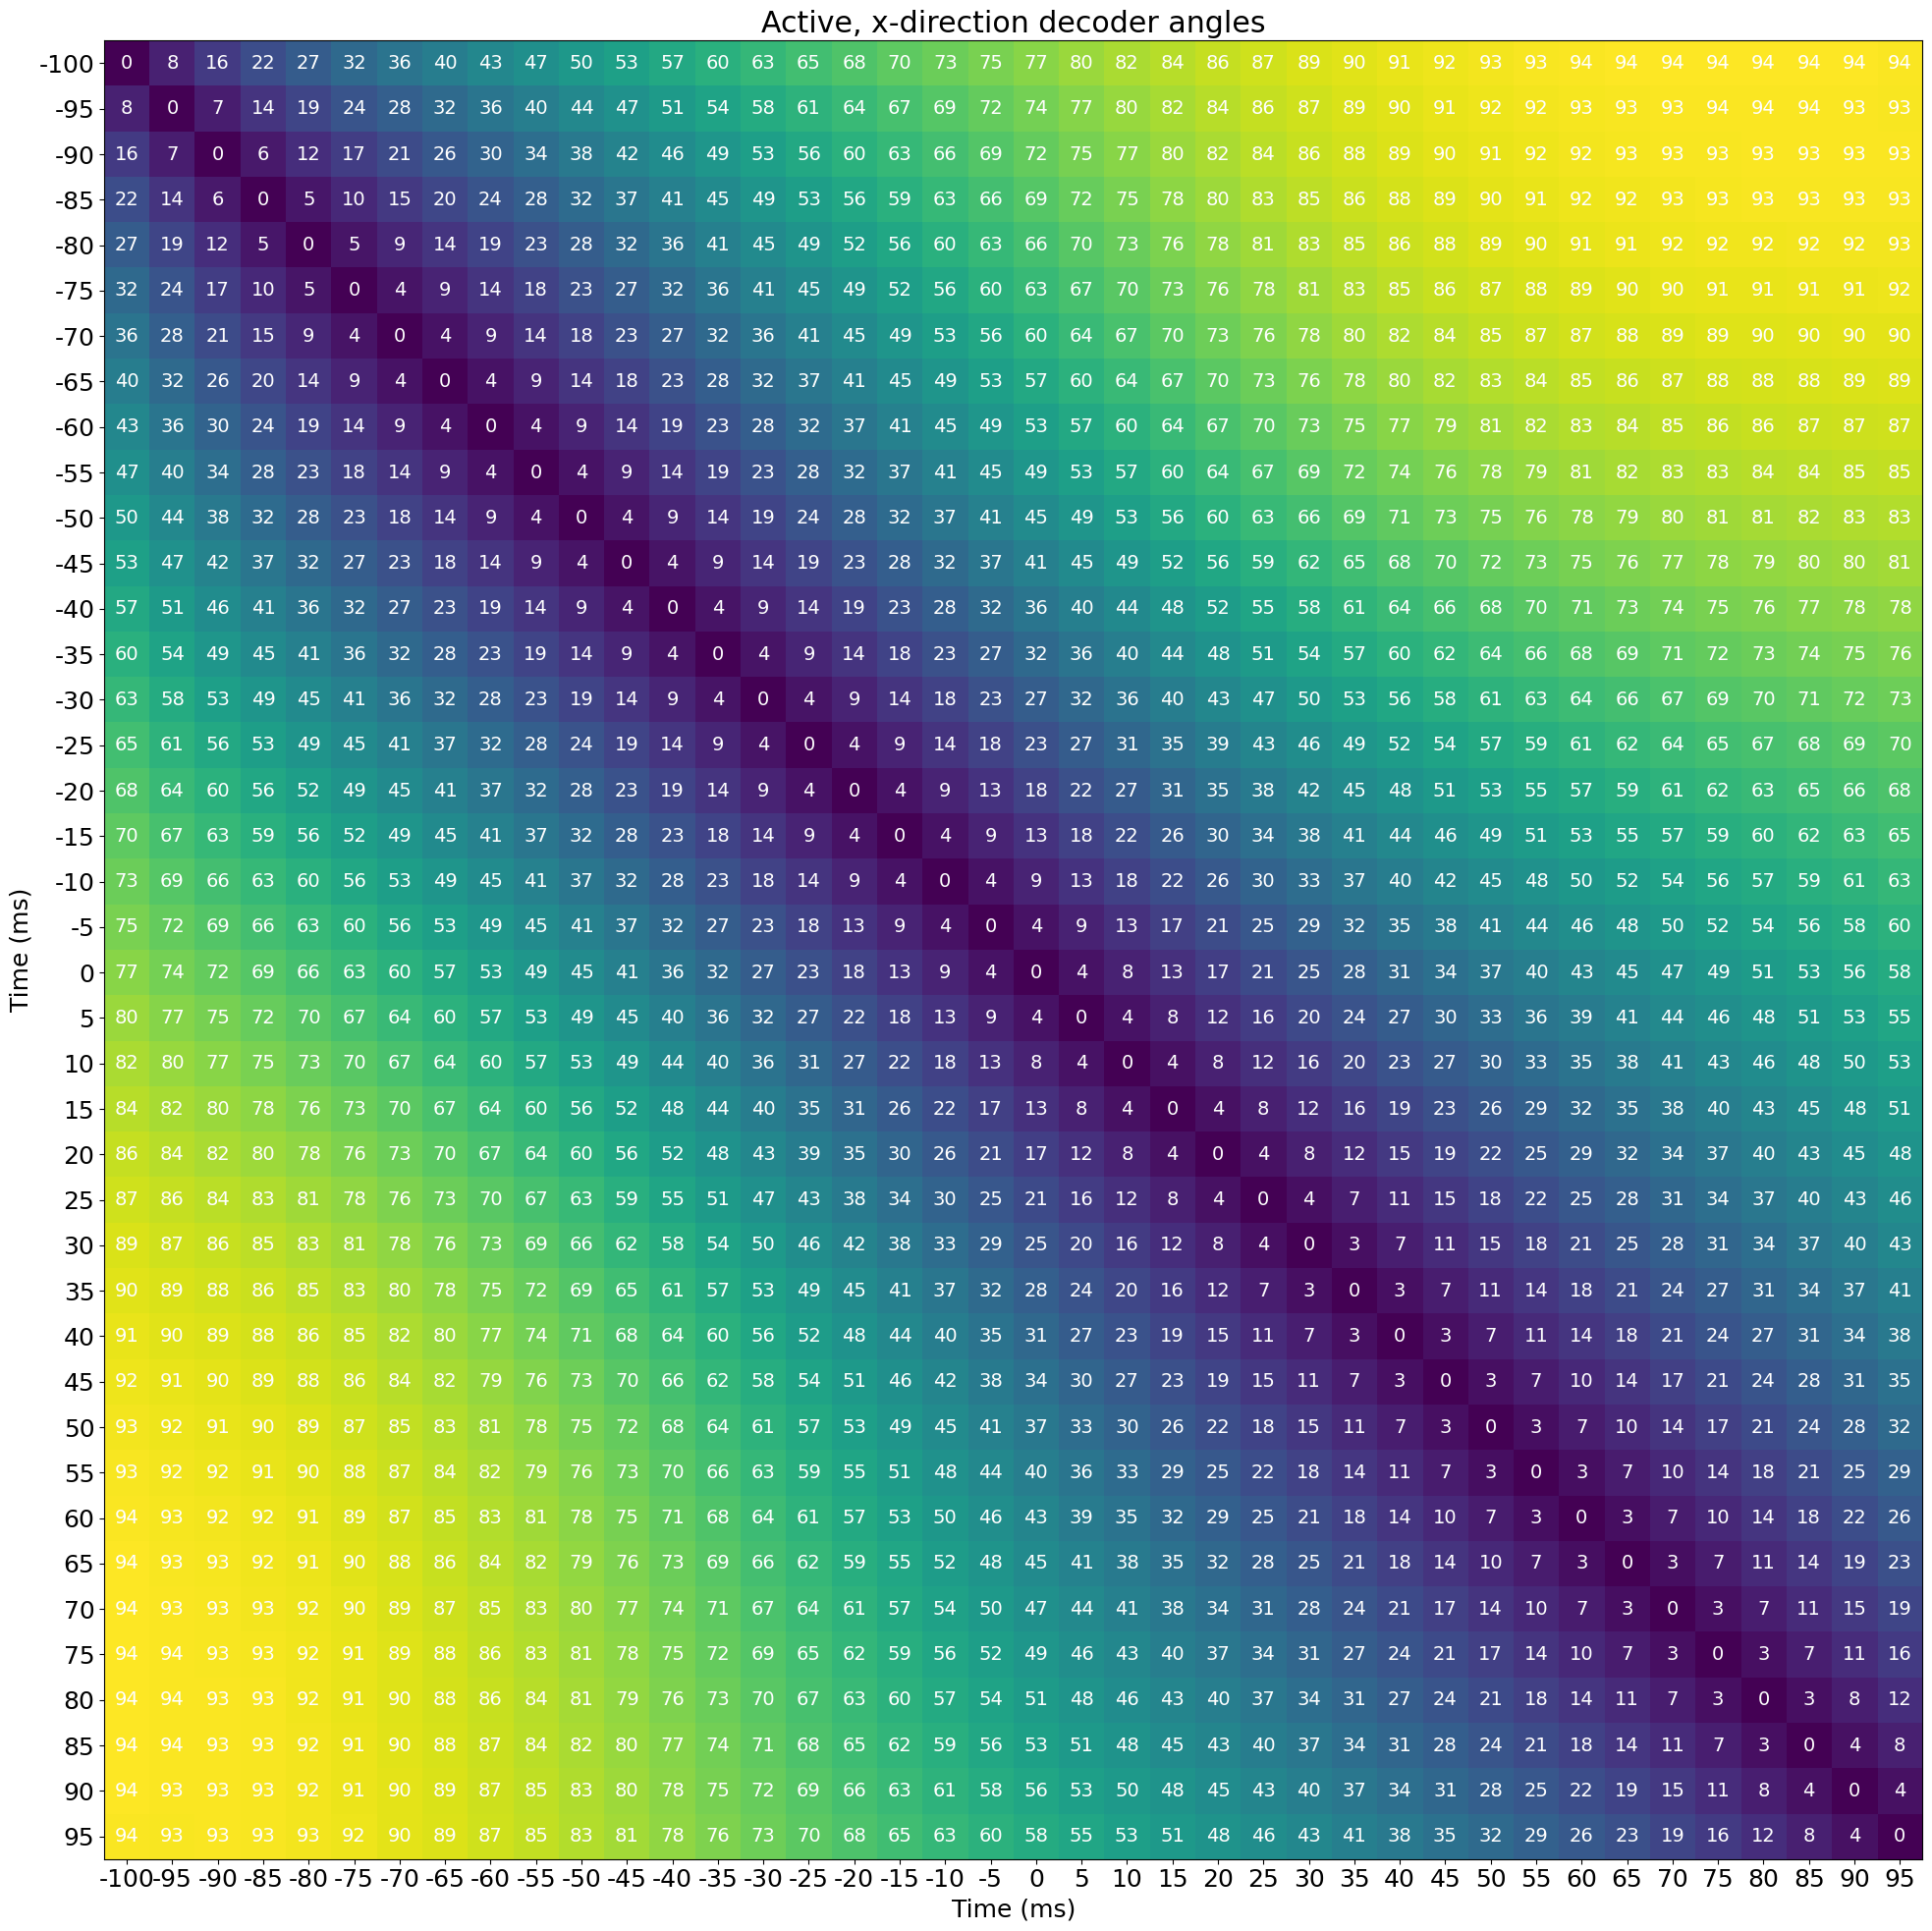

In [174]:
angDist_array = nans([len(active_coefs_arr),len(active_coefs_arr)])

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        angDist_array[i,j] = math.degrees(angle_between(active_coefs_arr[i,0,:],active_coefs_arr[j,0,:]))
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(angDist_array)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.arange(len(lag_axis)))
ax.set_xticklabels(labels=lag_axis)
ax.set_yticklabels(labels=lag_axis)

ax.set_title("Active, x-direction decoder angles")

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
plt.show()

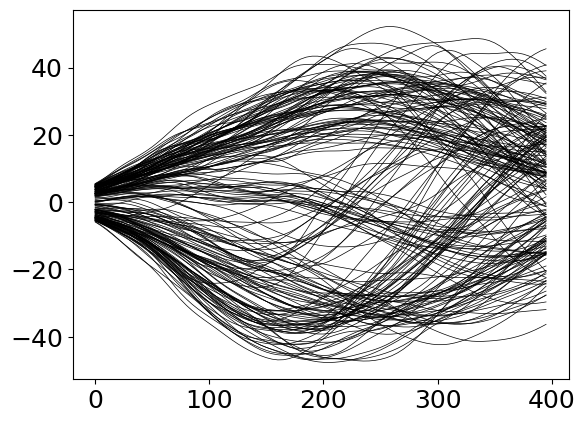

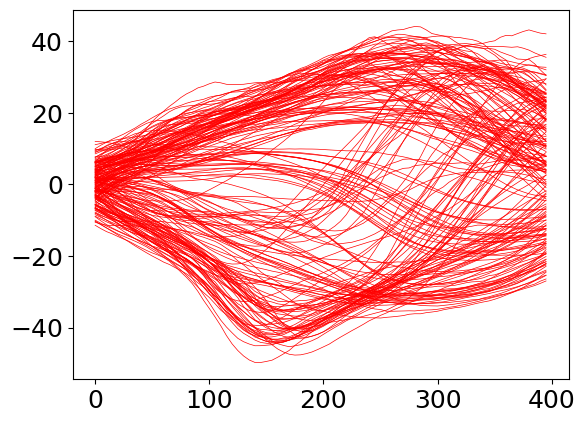

In [194]:
plt.plot(np.arange(0, 400, 5),kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==400)[0,0],0].T,color = 'k',linewidth = .5)
plt.show()

start, end = 0+np.argmax(active_r2), -40+np.argmax(active_r2)
X_trial = active_rates_array[:,start:end,:]
X_flat = X_trial.reshape((X_trial.shape[0]* X_trial.shape[1]),X_trial.shape[2])
X_proc = (X_flat - np.nanmean(X_flat,axis=0))/np.nanstd(X_flat,axis=0)
y_proc = (y_flat - np.nanmean(y_flat,axis=0))/np.nanstd(y_flat,axis=0)
lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-4,4,9)})
lr_all.fit(X_proc, y_proc)

y_pred = lr_all.predict(X_proc)
Y = y_pred*np.nanstd(y_flat,axis=0) + np.nanmean(y_flat,axis=0)
Y = Y.reshape(active_n_trials,-1,2)

plt.plot(np.arange(0, 400, 5),Y[:,:,0].T,color = 'red',linewidth = .5)


15
0.3926675616049441


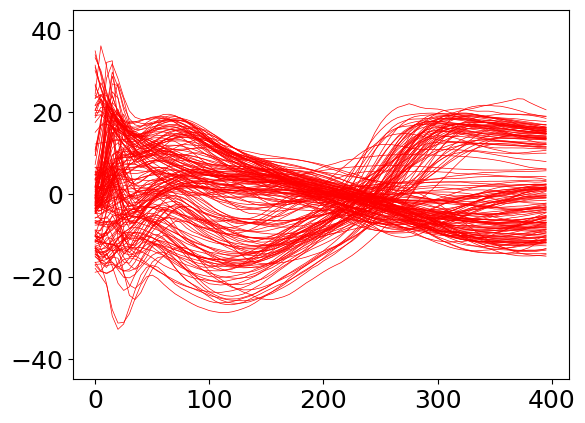

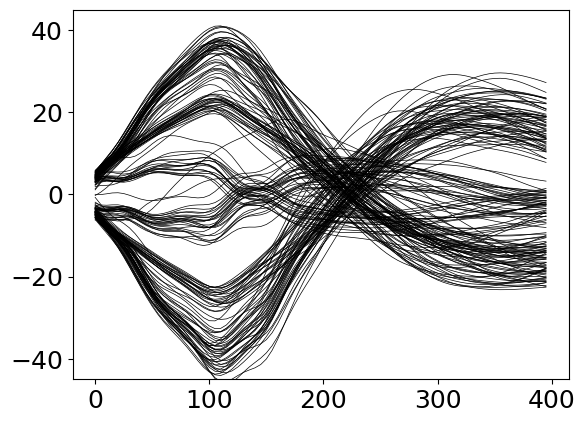

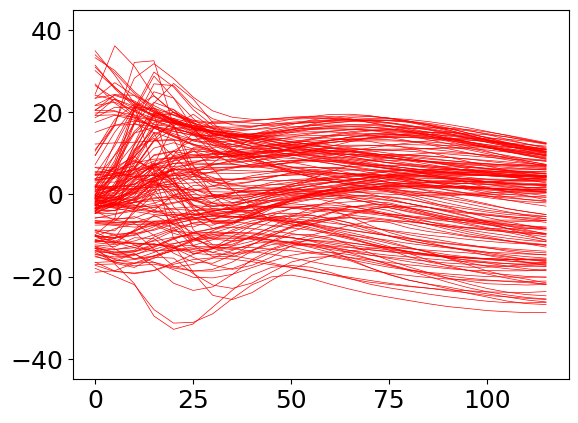

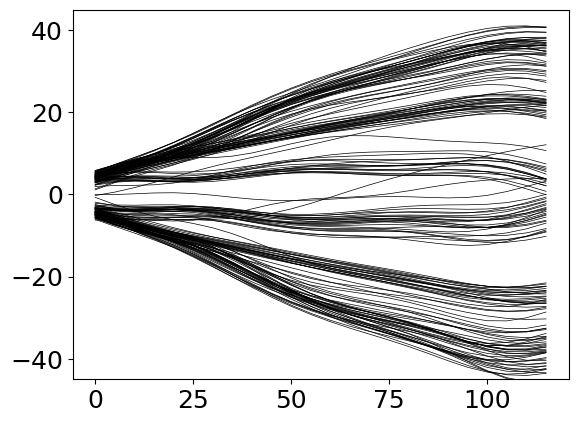

In [199]:
id = np.argmax(active_r2)
# id = np.argwhere(lag_axis==-45)[0,0]
print(lag_axis[id])
start, end = 0+id, -40+id
X_trial = active_rates_array[:,start:end,:]
X_flat = X_trial.reshape((X_trial.shape[0]* X_trial.shape[1]),X_trial.shape[2])
X_proc = (X_flat - np.nanmean(X_flat,axis=0))/np.nanstd(X_flat,axis=0)
y_proc = (y_flat - np.nanmean(y_flat,axis=0))/np.nanstd(y_flat,axis=0)
lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-4,4,9)})
lr_all.fit(X_proc, y_proc)

start, end = 0+id, -40+id
X_trial_0 = passive_rates_array[:,start:end,:]
X_flat_0 = X_trial_0.reshape((X_trial_0.shape[0]* X_trial_0.shape[1]),X_trial_0.shape[2])
X_proc_0 = (X_flat_0 - np.nanmean(X_flat_0,axis=0))/np.nanstd(X_flat_0,axis=0)
kinemaic_array = passive_vel_array
y_trial_0 = kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==400)[0,0],:]
y_flat_0 = y_trial_0.reshape(-1,2)

y_pred = lr_all.predict(X_proc_0)
Y = y_pred*np.nanstd(y_flat_0,axis=0) + np.nanmean(y_flat_0,axis=0)
Y = Y.reshape(passive_n_trials,-1,2)
from sklearn.metrics import r2_score
print(r2_score(y_flat_0, Y.reshape(-1,2)))

plt.plot(np.arange(0, 400, 5),Y[:,:,0].T,color = 'red',linewidth = .5)
# plt.ylim([-0.6,0.6])
plt.ylim([-45,45])
plt.show()
plt.plot(np.arange(0, 400, 5),kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==400)[0,0],0].T,color = 'k',linewidth = .5)
# plt.ylim([-0.6,0.6])
plt.ylim([-45,45])
plt.show()


plt.plot(np.arange(0, 120, 5),Y[:,:24,0].T,color = 'red',linewidth = .5)
# plt.ylim([-0.6,0.6])
plt.ylim([-45,45])
plt.show()
plt.plot(np.arange(0, 120, 5),kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==120)[0,0],0].T,color = 'k',linewidth = .5)
# plt.ylim([-0.6,0.6])
plt.ylim([-45,45])
plt.show()


In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

vel_axis = np.arange(-100, 500, dataset.bin_width)
lag_axis = np.arange(-100, 100, 5)
passive_coefs_arr = nans([len(lag_axis), 2,n_neurons])
passive_r2 = nans([len(lag_axis)])
kinemaic_array = passive_vel_array

y_trial = kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==120)[0,0],:]
y_flat = y_trial.reshape(-1,2)
for i in range(len(lag_axis)):
    start, end = 0+i, -96+i
    X_trial = passive_rates_array[:,start:end,:]
    lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-4,4,9)})
    X_flat = X_trial.reshape((X_trial.shape[0]* X_trial.shape[1]),X_trial.shape[2])
    X_proc = (X_flat - np.nanmean(X_flat,axis=0))/np.nanstd(X_flat,axis=0)
    y_proc = (y_flat - np.nanmean(y_flat,axis=0))/np.nanstd(y_flat,axis=0)
    lr_all.fit(X_proc, y_proc)
    passive_coefs_arr[i,:,:] = lr_all.best_estimator_.coef_
    kf = KFold(n_splits=5, shuffle = True, random_state = 42)
    true_concat = nans([len(y_flat),2])
    pred_concat = nans([len(y_flat),2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,passive_n_trials)):
            X_train, X_test, y_train, y_test = process_train_test(X_trial,y_trial,training_set,test_set)
            lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 4, 9)}) 
            lr.fit(X_train, y_train)
            y_test_predicted = lr.predict(X_test)
            n = y_test_predicted.shape[0]
            true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
            pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
            trial_save_idx += n
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean) 
    passive_r2[i] = R2

Text(0, 0.5, 'R2')

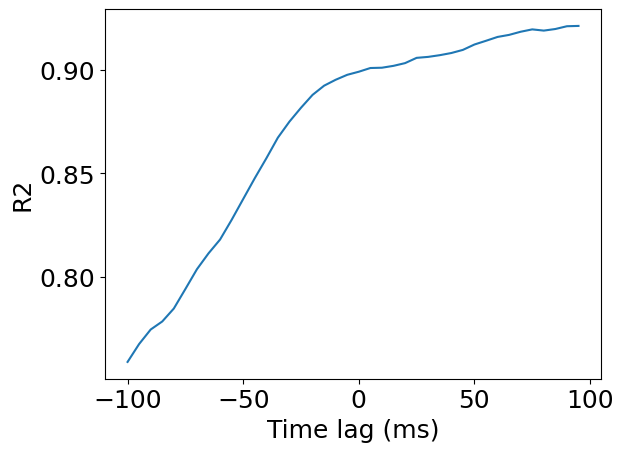

In [212]:
plt.plot(lag_axis, passive_r2)
plt.xlabel("Time lag (ms)")
plt.ylabel('R2')

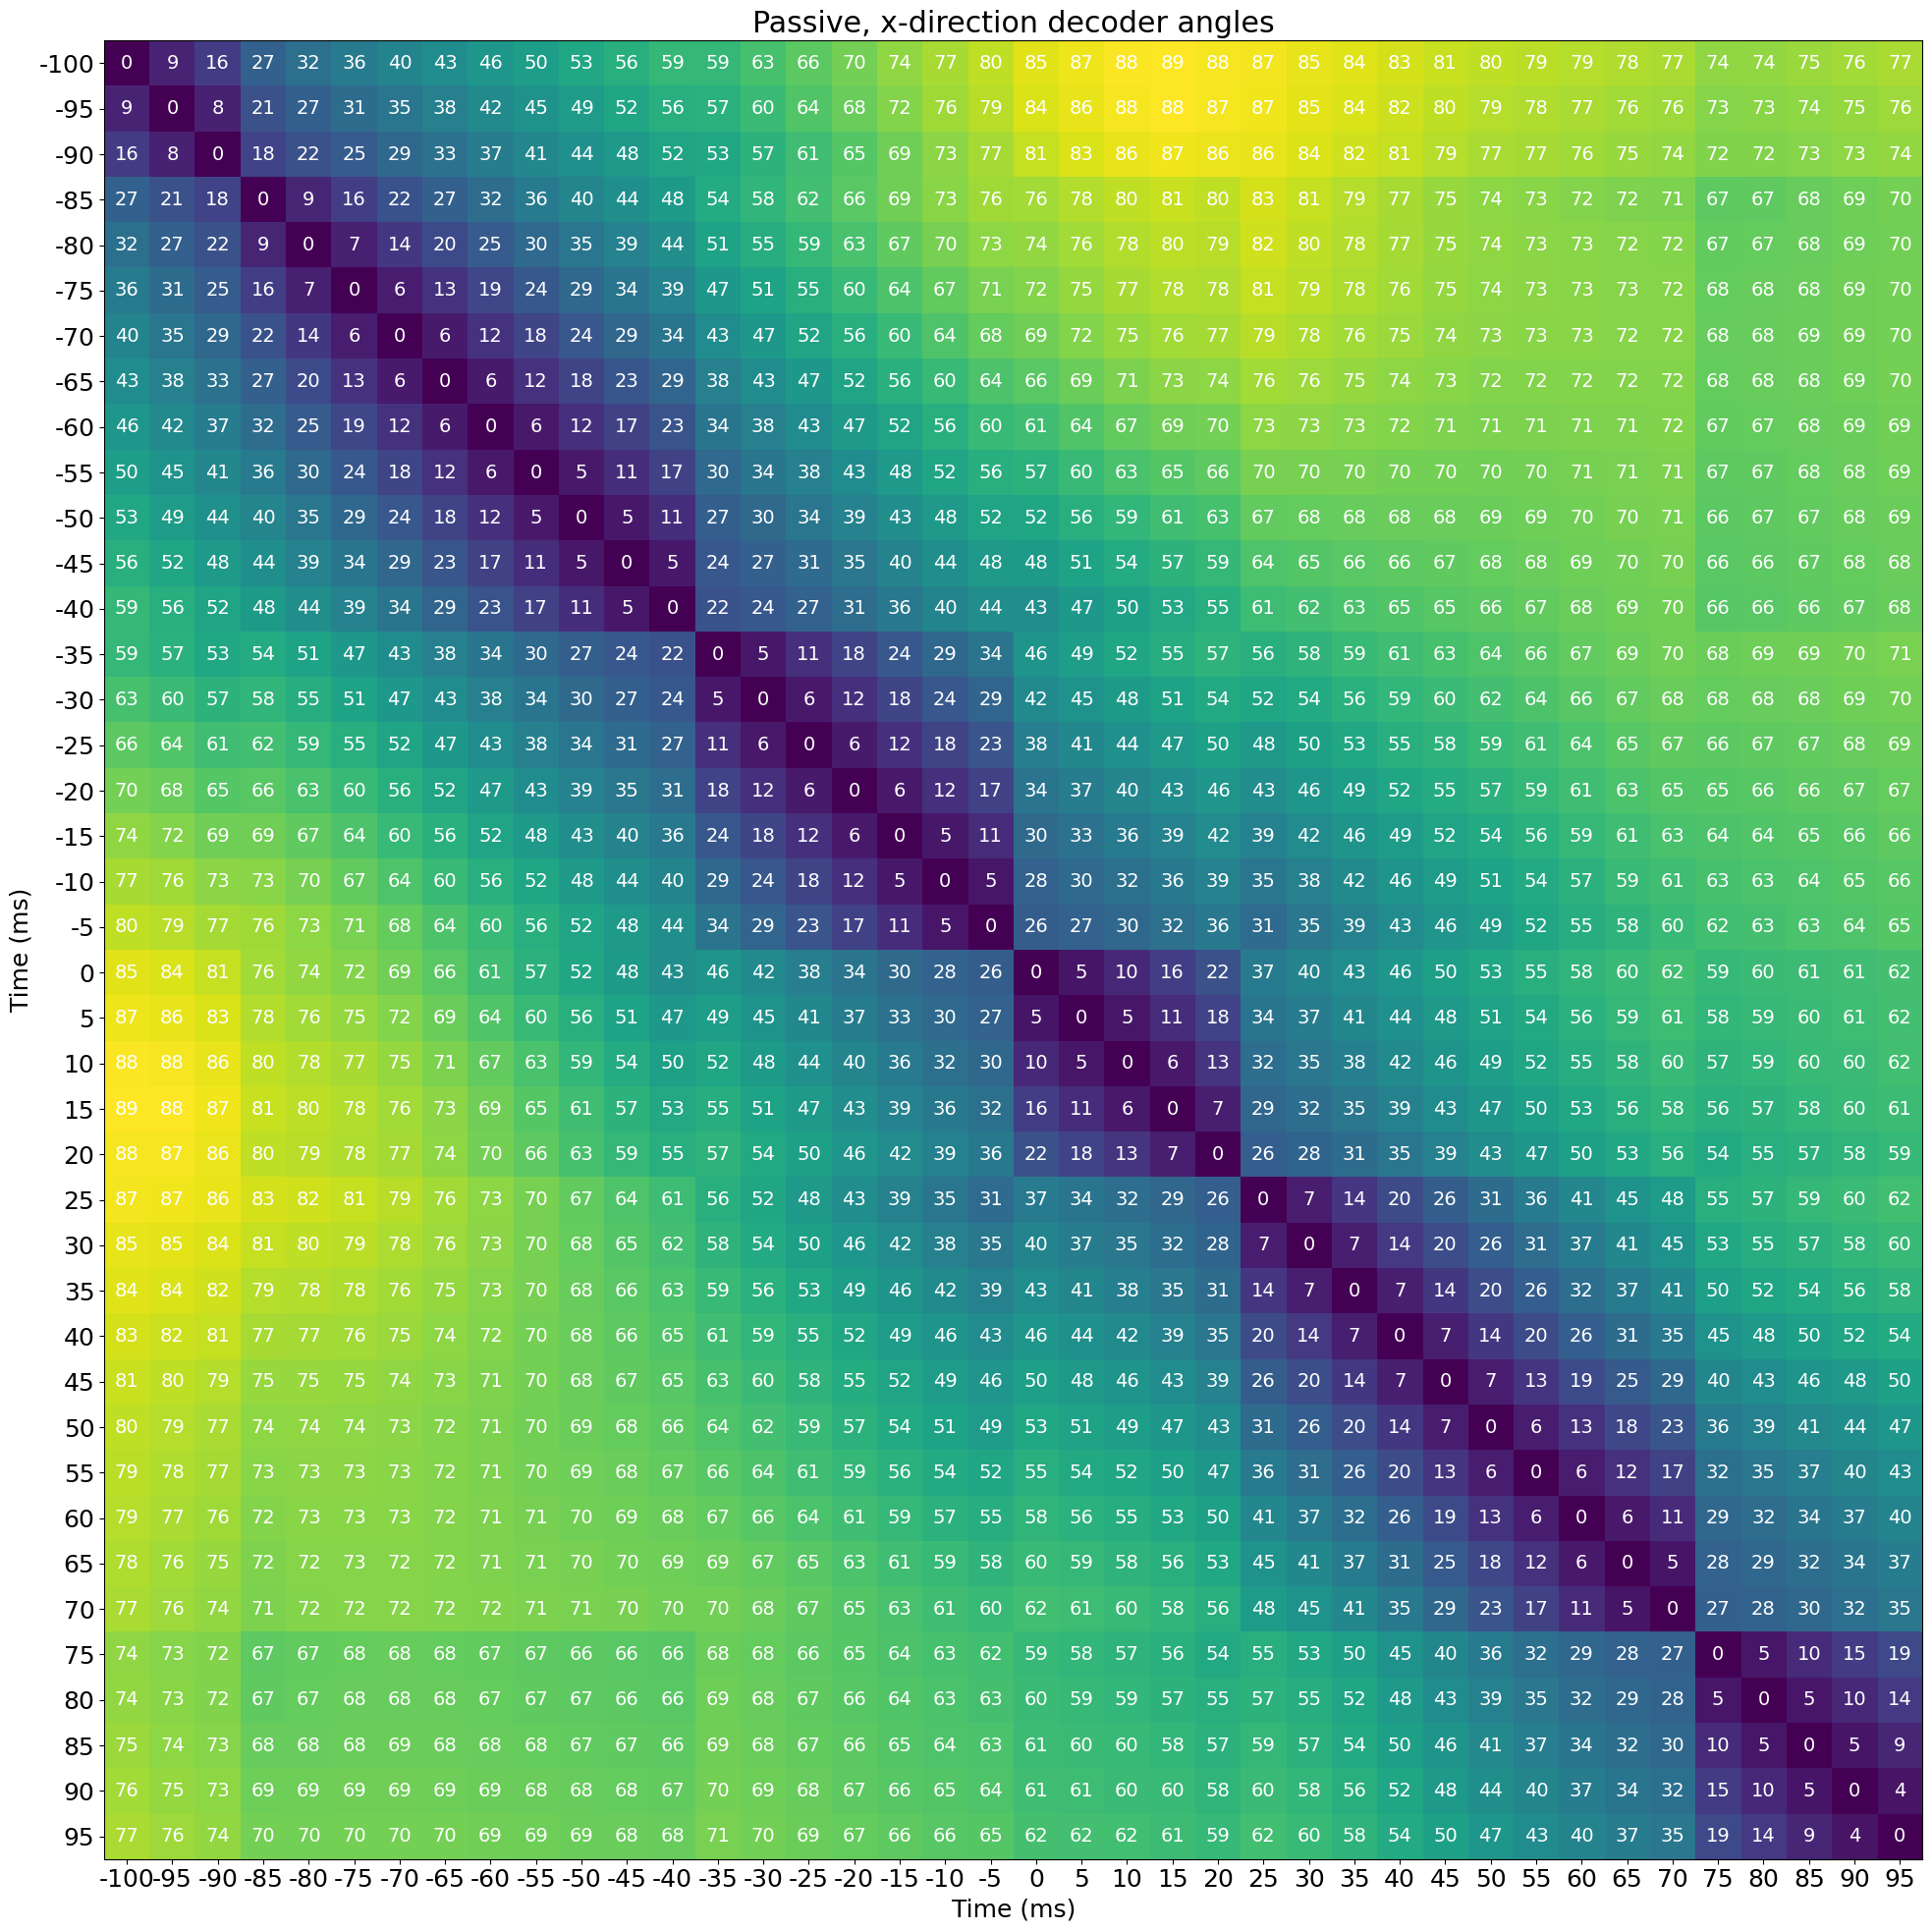

In [213]:
angDist_array = nans([len(passive_coefs_arr),len(passive_coefs_arr)])

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        angDist_array[i,j] = math.degrees(angle_between(passive_coefs_arr[i,0,:],passive_coefs_arr[j,0,:]))
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(angDist_array)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Time (ms)')

ax.set_xticks(np.arange(len(lag_axis)))
ax.set_yticks(np.arange(len(lag_axis)))
ax.set_xticklabels(labels=lag_axis)
ax.set_yticklabels(labels=lag_axis)

ax.set_title("Passive, x-direction decoder angles")

for i in range(len(lag_axis)):
    for j in range(len(lag_axis)):
        text = ax.text(j, i, str(int(angDist_array[i, j])),
                        ha="center", va="center", color="w", fontsize=14)
plt.tight_layout()
plt.show()

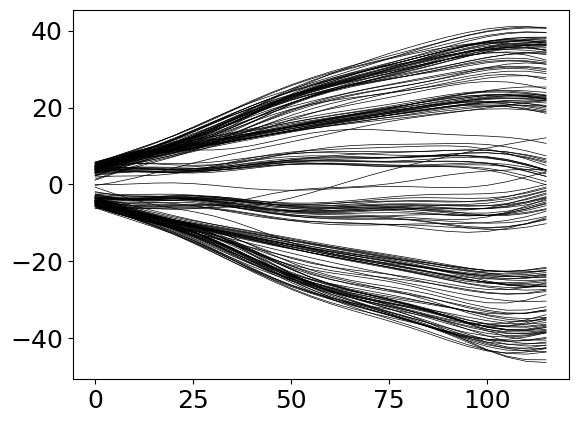

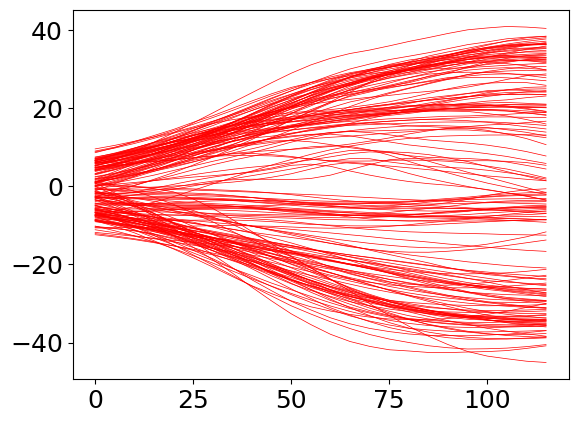

In [214]:
plt.plot(np.arange(0, 120, 5),kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==120)[0,0],0].T,color = 'k',linewidth = .5)
plt.show()

start, end = 0+np.argmax(passive_r2), -96+np.argmax(passive_r2)
X_trial = passive_rates_array[:,start:end,:]
X_flat = X_trial.reshape((X_trial.shape[0]* X_trial.shape[1]),X_trial.shape[2])
X_proc = (X_flat - np.nanmean(X_flat,axis=0))/np.nanstd(X_flat,axis=0)
y_proc = (y_flat - np.nanmean(y_flat,axis=0))/np.nanstd(y_flat,axis=0)
lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-4,4,9)})
lr_all.fit(X_proc, y_proc)
y_pred = lr_all.predict(X_proc)
Y = y_pred*np.nanstd(y_flat,axis=0) + np.nanmean(y_flat,axis=0)
Y = Y.reshape(passive_n_trials,-1,2)

plt.plot(np.arange(0, 120, 5),Y[:,:,0].T,color = 'red',linewidth = .5)


20
0.27876733551416066


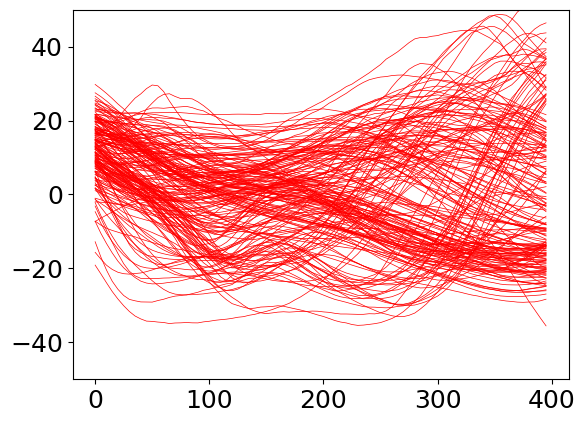

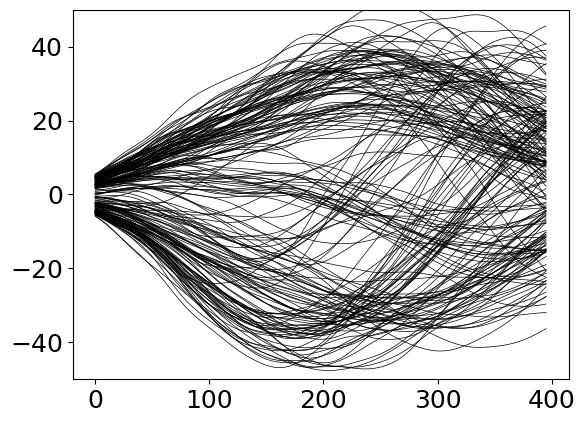

In [222]:
# id = np.argmax(passive_r2)
id = np.argwhere(lag_axis==20)[0,0]
print(lag_axis[id])
start, end = 0+id, -96+id
X_trial = passive_rates_array[:,start:end,:]
X_flat = X_trial.reshape((X_trial.shape[0]* X_trial.shape[1]),X_trial.shape[2])
X_proc = (X_flat - np.nanmean(X_flat,axis=0))/np.nanstd(X_flat,axis=0)
y_proc = (y_flat - np.nanmean(y_flat,axis=0))/np.nanstd(y_flat,axis=0)
lr_all = GridSearchCV(Ridge(),{'alpha':np.logspace(-4,4,9)})
lr_all.fit(X_proc, y_proc)

vel_axis = np.arange(-100, 500, dataset.bin_width)
start, end = 0+id, -40+id
X_trial_0 = active_rates_array[:,start:end,:]
X_flat_0 = X_trial_0.reshape((X_trial_0.shape[0]* X_trial_0.shape[1]),X_trial_0.shape[2])
X_proc_0 = (X_flat_0 - np.nanmean(X_flat_0,axis=0))/np.nanstd(X_flat_0,axis=0)
kinemaic_array = active_vel_array
y_trial_0 = kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==400)[0,0],:]
y_flat_0 = y_trial_0.reshape(-1,2)

y_pred = lr_all.predict(X_proc_0)
Y = y_pred*np.nanstd(y_flat_0,axis=0) + np.nanmean(y_flat_0,axis=0)
Y = Y.reshape(active_n_trials,-1,2)
from sklearn.metrics import r2_score
print(r2_score(y_flat_0, Y.reshape(-1,2)))

plt.plot(np.arange(0, 400, 5),Y[:,:,0].T,color = 'red',linewidth = .5)
# plt.ylim([-0.6,0.6])
plt.ylim([-50,50])
plt.show()
plt.plot(np.arange(0, 400, 5),kinemaic_array[:,np.argwhere(vel_axis==0)[0,0]:np.argwhere(vel_axis==400)[0,0],0].T,color = 'k',linewidth = .5)
# plt.ylim([-0.6,0.6])
plt.ylim([-50,50])
plt.show()

